### In order to run CNN model, required files are to be downloaded from the link "http://www.dna.bio.keio.ac.jp/smiles/" as CNN based model is adapted from Hirohara et al. Copy the downloaded files to a folder named "CNN_codes" and keep the "CNN_codes" folder in the folder "supp_scripts"

In [1]:
import os
os.system("mkdir ../../supp_scripts/CNN_codes")

0

In [2]:
! wget --quiet http://www.dna.bio.keio.ac.jp/smiles/SCFPfunctions.py -P ../../supp_scripts/CNN_codes 
! wget --quiet http://www.dna.bio.keio.ac.jp/smiles/SCFPmodel.py -P ../../supp_scripts/CNN_codes
! wget --quiet http://www.dna.bio.keio.ac.jp/smiles/evaluate-CV.py -P ../../supp_scripts/CNN_codes
! wget --quiet http://www.dna.bio.keio.ac.jp/smiles/evaluate-challenge.py -P ../../supp_scripts/CNN_codes
! wget --quiet http://www.dna.bio.keio.ac.jp/smiles/feature.py -P ../../supp_scripts/CNN_codes
! wget --quiet http://www.dna.bio.keio.ac.jp/smiles/trainer-CV.py -P ../../supp_scripts/CNN_codes
! wget --quiet http://www.dna.bio.keio.ac.jp/smiles/trainer-challenge.py -P ../../supp_scripts/CNN_codes
! wget --quiet http://www.dna.bio.keio.ac.jp/smiles/README -P ../../supp_scripts/CNN_codes

In [11]:
#!/usr/bin/env python 
# coding:utf-8

import time, argparse, gc, os
import copy
import sys
import tqdm
import json
import gc
import numpy as np
import pandas as pd

from rdkit import Chem

import sklearn
from sklearn.metrics import accuracy_score

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, TensorDataset, SubsetRandomSampler


# custom functions
supp_script_path = '../../supp_scripts/'
sys.path.append(supp_script_path) # path for support scripts folder
sys.path.append(supp_script_path + 'CNN_codes/')
from feature import *
import SCFPfunctions as Mf

import supp_utils as su

# set gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device,torch.cuda.is_available()

(device(type='cuda'), True)

In [12]:
# To remove warnings
import warnings
warnings.filterwarnings('ignore')  # "error", "ignore", "always", "default", "module" or "once"

# To remove rdkit warning
from rdkit import RDLogger
lg = RDLogger.logger()
lg.setLevel(RDLogger.CRITICAL)

In [13]:
parameter_filename = "parameters_CNN.json" 

In [14]:
# Whole section is to read parameters from the parameter file
parameter_file = open(parameter_filename)
parameters = json.load(parameter_file)
parameter_file.close()

# User inputs
input_file_train = parameters["input_file_train"] # input file
input_file_test = parameters["input_file_test"] # input file

trial = parameters["trial"] # setting False saves the output files else not saved

if not trial:
    run_folder = parameters["run_folder"]

gpu_id = int(parameters["gpu_id"])
if gpu_id != None:
    device = "cuda:" + str(gpu_id)
else:
    gpu_id = 0

k_fold_value = int(parameters["k_fold_value"]) # Number of folds

lensize = int(parameters["sequence_length_cutoff"]["lensize"]) # feature vector size
atomsize = int(parameters["sequence_length_cutoff"]["atomsize"]) # max length of molecule


learning_rate = float(parameters["network_parameters"]["learning_rate"])
epochs = int(parameters["network_parameters"]["epochs"])
batchsize = int(parameters["network_parameters"]["batchsize"])
enable_class_weight = parameters["network_parameters"]["enable_class_weight"]

# k = window size
# s = strides
# f = number of filters

# first convolution
k1 = int(parameters["conv1"]["k1"])
s1 = int(parameters["conv1"]["s1"])
f1 = int(parameters["conv1"]["f1"])

# max pooling 1 
k2 = int(parameters["pool1"]["k2"])
s2 = int(parameters["pool1"]["s2"])

# second convolution
k3 = int(parameters["conv2"]["k3"])
s3 = int(parameters["conv2"]["s3"])
f3 = int(parameters["conv2"]["f3"])

# max pooling 2
k4 = int(parameters["pool2"]["k4"])
s4 = int(parameters["pool2"]["s4"])

# number of hidden layers
n_hid = int(parameters["fc_layer_parameters"]["n_hid"])

os.system("mkdir " + str(run_folder))
if not trial:
    network_parameter_output = open(str(run_folder) + "/network_parameters.txt","w",1)
    for parameter in parameters:
        network_parameter_output.write(str(parameter) + " = " + str(parameters[parameter]) + "\n")

In [15]:
# CNN network
class Net(nn.Module):
    def __init__(self, atomsize, lensize, k1, s1, f1, k2, s2, k3, 
                 s3, f3, k4, s4, n_hid, n_out):
        
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, f1, (k1,lensize),padding=(k1//2,0),stride=(s1,s1))
        self.bn1 = nn.BatchNorm2d(f1)
        self.leakyr = nn.LeakyReLU()
        self.pool1 = nn.AvgPool2d((k2,1),stride=(s2,s2),padding=(k2//2,0))
        self.conv2 = nn.Conv2d(f1,f3,(k3,1),stride=(s3,s3),padding=(k3//2,0))
        self.bn2 = nn.BatchNorm2d(f3)
        self.pool2 = nn.AvgPool2d((k4,1),stride=(s4,s4),padding=(k4//2,0))
        self.maxpool = nn.MaxPool2d(kernel_size=2),
        self.fc1 = nn.Linear(f3, n_hid)
        self.fc2 = nn.Linear(n_hid, n_out)
        self.bn3 = nn.BatchNorm1d(n_hid)
        
        self.dropout = nn.Dropout(p=0.2)
        
    def forward(self, x):
        x = self.pool1(self.leakyr(self.bn1(self.conv1(x))))
        x = self.pool2(self.leakyr(self.bn2(self.conv2(x))))
        x = F.max_pool2d(x,kernel_size=x.size()[2:])
        x = x.view(x.size(0),-1)
        x = self.fc1(x)
        x = self.bn3(x)
        x = self.dropout(self.leakyr(x))
        x = self.fc2(x)
        return x

In [16]:
# Reading train_valid and test splits from the file and make it to a dataframe
smiles_label_test = {line.split()[0]:line.split()[1] for line in open(input_file_test,"r").readlines()}
smiles_label_test = dict(sorted(smiles_label_test.items(), key=lambda item: item[1]))

smiles_label_train = {line.split()[0]:line.split()[1] for line in open(input_file_train,"r").readlines()}
smiles_label_train = dict(sorted(smiles_label_train.items(), key=lambda item: item[1]))

train_valid_df = su.dict_to_label(smiles_label_train)
train_valid_df = train_valid_df
test_df = su.dict_to_label(smiles_label_test)
test_df = test_df.sample(frac=1).reset_index(drop=True)

n_out = len(set(test_df["Label"].to_list()))

In [17]:
# Increase the size of padding with maximum sequence length and a little
# Enable this if all molecules from the data has to be included
# else cutoff is taken, mentioned in the parameter file
max_sequence_length = max([len(smiles) for smiles in list(smiles_label_train)] + [len(smiles) for smiles in list(smiles_label_test)])
if max_sequence_length > atomsize:
    atomsize = (max_sequence_length+(100-(max_sequence_length%100))) + 100

Best model
LOSS train: 0.08369750274752064  val: 0.12088127061724663 	ACCU train: 0.9859913793103449  val: 0.965625
Final model
LOSS train: 0.046231720853468466  val: 0.12348292544484138 	ACCU train: 0.9935344827586207  val: 0.971875


Best model
LOSS train: 0.03995199663157778  val: 0.1582852654159069 	ACCU train: 0.9917385057471264  val: 0.970125
Final model
LOSS train: 0.03995199663157778  val: 0.1582852654159069 	ACCU train: 0.9917385057471264  val: 0.970125


KeyboardInterrupt: 

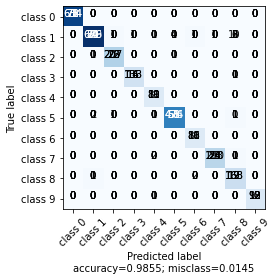

In [18]:
for fold in range(k_fold_value):
    
    if not trial:
        log_file = open(str(run_folder) + "/model_" + str(fold) + ".txt","w")
        model_output_name = str(run_folder) + "/model_" + str(fold) + ".pth"
    
    piece_count = fold + 1
    
    # create train and valid set for the fold
    train,valid,piece_count = su.CV.get_K_fold_cv_data(train_valid_df,k_fold_value,1,shuffle_output=True)
    
    # Make feature matrix for train, valid, test
    su.write_cid_smiles_output(train,"train_file.txt")
    x_train,y_train = su.CNN.make_grid("train_file.txt",lensize,atomsize)
    
    su.write_cid_smiles_output(valid,"valid_file.txt")
    x_valid,y_valid = su.CNN.make_grid("valid_file.txt",lensize,atomsize)
    
    su.write_cid_smiles_output(test_df,"test_file.txt")
    x_test,y_test = su.CNN.make_grid("test_file.txt",lensize,atomsize)

    
    # calculate class_weight
    if enable_class_weight:
        class_weight = torch.FloatTensor(su.get_class_weight(train)).cuda(gpu_id)
        if not trial:
            log_file.write("Class weight for loss (balancing weights)= " + str(class_weight) + "\n")
    
    # Writing output
    if not trial:
        train_class_distriution = su.DNN.get_cluster_count_from_label([entry[0] for entry in y_train])
        valid_class_distriution = su.DNN.get_cluster_count_from_label([entry[0] for entry in y_valid])
        test_class_distriution = su.DNN.get_cluster_count_from_label([entry[0] for entry in y_test])
        log_file.write("Training : Class distribution = " + str(train_class_distriution) + "\n")
        log_file.write("Valid : Class distribution = " + str(valid_class_distriution) + "\n")
        log_file.write("Test : Class distribution = " + str(test_class_distriution) + "\n")
    
    
    # Creating dataloader
    train_loader = su.CV.get_dataloader(x_train,y_train.squeeze(),batchsize)
    valid_loader = su.CV.get_dataloader(x_valid,y_valid.squeeze(),batchsize)
    test_loader = su.CV.get_dataloader(x_test,y_test.squeeze(),batchsize)
    
    
    # initializing network
    model = Net(atomsize, lensize, k1, s1, f1, k2, s2, k3, s3, f3, k4, s4, n_hid, n_out)
    model.cuda(gpu_id)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    if enable_class_weight:
        criterion = nn.CrossEntropyLoss(weight=class_weight)
    else:
        criterion = nn.CrossEntropyLoss()
    
    if not trial:
        log_file.write("Epochs = " + str(epochs) + "\n")
        log_file.write("Learning rate = " + str(learning_rate) + "\n")
        log_file.write("optimizer = " + str("Adam") + "\n")
        log_file.write("criterion = " + str("CrossEntropyLoss") + "\n")
    
    
    # Training the network
    train_loss_list = []
    train_accu_list = []

    val_loss_list = []
    val_accu_list = []
    
    train_f1_list = []
    valid_f1_list = []
    if not trial:
        log_file.write("Epoch\tLOSStrain\tLOSSval\tACCUtrain\tACCUval\n") 

    loop = tqdm.tqdm(range(epochs), total=epochs,leave=False)
    for epoch in loop:

        train_loss, train_accu = su.CNN.train(model,criterion,optimizer,train_loader,device)
        val_loss,val_accu = su.CNN.validate(model,criterion,valid_loader,device)
        
        
        # For callback
        # Callback saves the best model based on the below priority
        # validation loss --> validation accuracy--> training loss--> training accuracy
        if epoch == 0: 
            torch.save(model.state_dict(), model_output_name)
            saved_model_id = epoch + 1
        
        if epoch != 0:
            current_epoch_values = [train_loss, train_accu,val_loss,val_accu]
            previous_epoch_values = [train_loss_list,train_accu_list,val_loss_list,val_accu_list]
            if su.callback(current_epoch_values,previous_epoch_values,model,model_output_name):
                model_copy = copy.deepcopy(model)
                saved_model_id = epoch + 1
        
        train_loss_list.append(train_loss)
        train_accu_list.append(train_accu)
        val_loss_list.append(val_loss)
        val_accu_list.append(val_accu)
        
        if not trial:
            log_file.write(str(epoch+1) + "\t" + str(train_loss) + "\t" + str(val_loss) + "\t" + str(train_accu) + "\t" + str(val_accu)  + "\n")
        loop.set_description("LOSS train:" + str(train_loss) + " val:" + str(val_loss) + " \tACCU train:" + str(train_accu) + " val:" + str(val_accu))
    
    torch.save(model_copy.state_dict(), model_output_name)
    
    log_file.write("\nChosen model = epoch number " + str(saved_model_id))
    
    # Re-initializing the model for getting statistics for all the three sets of data for the current fold
    model = Net(atomsize, lensize, k1, s1, f1, k2, s2, k3, s3, f3, k4, s4, n_hid, n_out)
    model.load_state_dict(torch.load(model_output_name), strict=True)
    model.to(device)

    if not trial: # classification report, loss, and accuracy for the datasets
        loss,accuracy,prediction_list = su.CNN.test(model,criterion,train_loader,device)
        image_name = str(run_folder) + "/train_" + str(fold) + ".png"
        report = su.confustion_matrix(prediction_list,image_name)
        log_file.write("\n\n\nTrain data : Accu-" + str(accuracy) + "\tLoss-" + str(loss) + "\n")
        log_file.write("Train data report \n-" + str(report) + "\n\n\n\n\n")
    
        loss,accuracy,prediction_list = su.CNN.test(model,criterion,valid_loader,device)
        image_name = str(run_folder) + "/valid_" + str(fold) + ".png"
        report = su.confustion_matrix(prediction_list,image_name)
        log_file.write("\n\n\nValid data : Accu-" + str(accuracy) + "\tLoss-" + str(loss) + "\n")
        log_file.write("Valid data report \n-" + str(report) + "\n\n\n\n\n")
        
        loss,accuracy,prediction_list = su.CNN.test(model,criterion,test_loader,device)
        image_name = str(run_folder) + "/test_" + str(fold) + ".png"
        report = su.confustion_matrix(prediction_list,image_name)
        log_file.write("\n\n\nTest data : Accu-" + str(accuracy) + "\tLoss-" + str(loss) + "\n")
        log_file.write("Test data report \n-" + str(report) + "\n\n\n\n\n")
        
    log_file.close()
    
    if fold == 0 and not trial:
        network_parameter_output.write("Used atomsize " + str(atomsize) + "\n")
        network_parameter_output.write("model = " + str(model) + "\n")
        network_parameter_output.close()
        
    # best validation loss
    index = val_loss_list.index(sorted(val_loss_list)[0]) # index of least loss
    print ("Best model")
    print ("LOSS train:",train_loss_list[index]," val:",val_loss_list[index], "\tACCU train:",train_accu_list[index]," val:",val_accu_list[index])
    print ("Final model")    
    print ("LOSS train:",train_loss," val:",val_loss, "\tACCU train:",train_accu," val:",val_accu)